# SentiScope

## Data Import and Pre-processing

In [2]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict, train_test_split, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import joblib
from datetime import datetime
import random


In [3]:
#Import pre-processed training data | 10K observations
clean_df = pd.read_csv("../raw_data/train_df_ml_clean.csv", nrows=10000)
display(clean_df.head(), clean_df.shape, clean_df["label"].value_counts(normalize=True))

,label,text,clean_text
0,1,Stuning even for the non-gamer: This sound tra...,stuning even for the nongamer this sound track...
1,1,The best soundtrack ever to anything.: I'm rea...,the best soundtrack ever to anything im readin...
2,1,Amazing!: This soundtrack is my favorite music...,amazing this soundtrack is my favorite music o...
3,1,Excellent Soundtrack: I truly like this soundt...,excellent soundtrack i truly like this soundtr...
4,1,"Remember, Pull Your Jaw Off The Floor After He...",remember pull your jaw off the floor after hea...


(10000, 3)

label
0    0.5097
1    0.4903
Name: proportion, dtype: float64

In [4]:
#Split training data into X and y | 10K observations
X_train = clean_df["clean_text"]
y_train = clean_df["label"].astype(int)
display(X_train.shape, y_train.shape)

(10000,)

(10000,)

In [5]:
# Implement GridSearch and model comparison | 10K observations
# Cross-validate
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Vectorize
vectorizer = TfidfVectorizer(ngram_range=(1,2))

# Define params
params = {
    "vectorizer__max_features": [1000, 5000, 10000],
    "model__C": [0.01, 0.1, 1, 10]
}

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": LinearSVC(max_iter=1000)
}

# Run GridSearch
best_params_list = []
for name, model in models.items():
    print(f"GridSearchCV for {name}")

    pipeline = Pipeline([
        ("vectorizer", vectorizer),
        ("model", model)
    ])

    grid = GridSearchCV(
        pipeline,
        param_grid=params,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)

    print(f"Best CV accuracy: {grid.best_score_}")
    print(f"Best parameters: {grid.best_params_}")
    best_params = {
        "model": name,
        "max_features": grid.best_params_["vectorizer__max_features"],
        "C": grid.best_params_["model__C"]
    }
    best_params_list.append(best_params)

    # Create classification report
    y_pred = grid.best_estimator_.predict(X_train)

    print("Classification report:")
    print(classification_report(y_train, y_pred))

GridSearchCV for Logistic Regression
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best CV accuracy: 0.8770999999999999
Best parameters: {'model__C': 10, 'vectorizer__max_features': 10000}
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5097
           1       0.99      0.99      0.99      4903

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

GridSearchCV for Linear SVM
Fitting 5 folds for each of 12 candidates, totalling 60 fits


KeyboardInterrupt: 

In [ ]:
# Define best params
best_params_df = pd.DataFrame(best_params_list)
best_params_df.set_index("model", inplace=True)
display(best_params_df)

,max_features,C
model,,
Logistic Regression,10000,10
Linear SVM,10000,1


In [2]:
#Import pre-processed training data | 100000K observations
clean_df_large = pd.read_csv("../raw_data/train_df_ml_clean.csv", nrows=100000)
display(clean_df_large.head(), clean_df_large.shape, clean_df_large["label"].value_counts(normalize=True))

,label,text,clean_text
0,1,Stuning even for the non-gamer: This sound tra...,stuning even for the nongamer this sound track...
1,1,The best soundtrack ever to anything.: I'm rea...,the best soundtrack ever to anything im readin...
2,1,Amazing!: This soundtrack is my favorite music...,amazing this soundtrack is my favorite music o...
3,1,Excellent Soundtrack: I truly like this soundt...,excellent soundtrack i truly like this soundtr...
4,1,"Remember, Pull Your Jaw Off The Floor After He...",remember pull your jaw off the floor after hea...


(100000, 3)

label
1    0.51267
0    0.48733
Name: proportion, dtype: float64

In [3]:
#Split training data into X and y | 100000K observations
X_train_large = clean_df_large["clean_text"]
y_train_large = clean_df_large["label"].astype(int)
display(X_train_large.shape, y_train_large.shape)

(100000,)

(100000,)

In [ ]:
# Implement models with optimized params | 100000K observations
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(C=best_params_df.loc["Logistic Regression"]["C"], max_iter=1000),
    "Linear SVM": LinearSVC(C=best_params_df.loc["Linear SVM"]["C"], max_iter=1000)
}

for name, model in models.items():
    print(f"Cross-validating {name}")

    params = best_params_df.loc[name]

    pipeline = Pipeline([
        ("vectorizer", TfidfVectorizer(ngram_range=(1,2), max_features=best_params_df.loc[name]["max_features"])),
        ("model", model)
    ])

    y_pred = cross_val_predict(pipeline, X_train_large, y_train_large, cv=cv, n_jobs=-1)

    acc = accuracy_score(y_train_large, y_pred)
    print(f"Accuracy: {acc}")

    print("Classification report:")
    print(classification_report(y_train_large, y_pred))

Cross-validating Logistic Regression
Accuracy: 0.89059
Classification report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89     48733
           1       0.89      0.90      0.89     51267

    accuracy                           0.89    100000
   macro avg       0.89      0.89      0.89    100000
weighted avg       0.89      0.89      0.89    100000

Cross-validating Linear SVM
Accuracy: 0.88961
Classification report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89     48733
           1       0.89      0.89      0.89     51267

    accuracy                           0.89    100000
   macro avg       0.89      0.89      0.89    100000
weighted avg       0.89      0.89      0.89    100000



In [ ]:
#Import pre-processed training data | 100K observations
n_rows = 360000
clean_df_full = pd.read_csv("../raw_data/train_df_ml_clean.csv", nrows=n_rows)
clean_df_full = clean_df_full.dropna(subset=["clean_text"])
display(clean_df_full.head(), clean_df_full.shape, clean_df_full["label"].value_counts(normalize=True))

,label,text,clean_text
0,1,Stuning even for the non-gamer: This sound tra...,stuning even for the nongamer this sound track...
1,1,The best soundtrack ever to anything.: I'm rea...,the best soundtrack ever to anything im readin...
2,1,Amazing!: This soundtrack is my favorite music...,amazing this soundtrack is my favorite music o...
3,1,Excellent Soundtrack: I truly like this soundt...,excellent soundtrack i truly like this soundtr...
4,1,"Remember, Pull Your Jaw Off The Floor After He...",remember pull your jaw off the floor after hea...


(360000, 3)

label
1    0.506531
0    0.493469
Name: proportion, dtype: float64

In [ ]:
#Split training data into X and y | 100K observations
X_train_full = clean_df_full["clean_text"]
y_train_full = clean_df_full["label"].astype(int)
display(X_train_full.shape, y_train_full.shape, clean_df_full["clean_text"].isna().sum())

(360000,)

(360000,)

np.int64(1)

In [1]:
max_features = 10000
logreg_C = 10

vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=max_features)
X_train_full_vec = vectorizer.fit_transform(X_train_full)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model = LogisticRegression(C=logreg_C, max_iter=1000)

NameError: name 'TfidfVectorizer' is not defined

[learning_curve] Training set sizes: [ 8000 26000 44000 62000 80000]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   19.1s finished


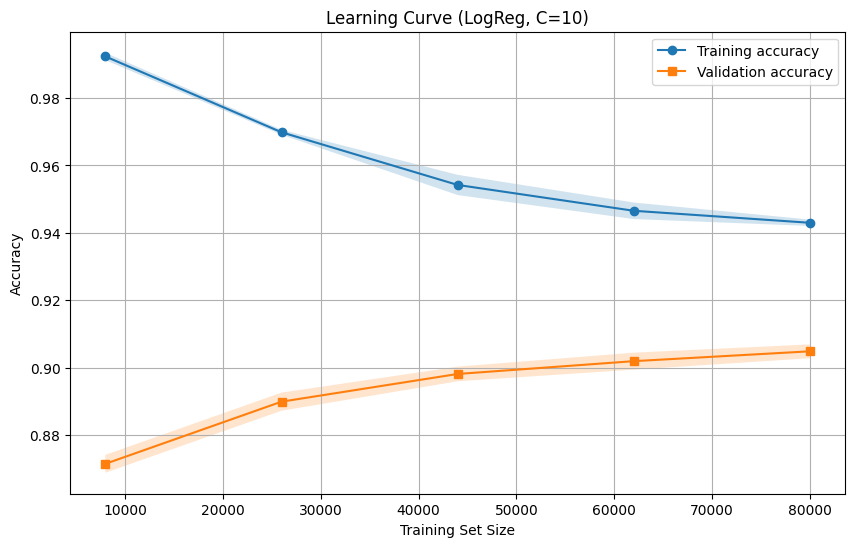

In [ ]:
# Estimate learning curve inputs
train_sizes, train_scores, val_scores = learning_curve(
    estimator=model,
    X=X_train_full_vec,
    y=y_train_full,
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

# Mean and std of training/ validation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, marker="o", label="Training accuracy")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)

plt.plot(train_sizes, val_mean, marker="s", label="Validation accuracy")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

plt.title(f"Learning Curve (LogReg, C={logreg_C})")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Import pre-processed test data | All observations
test_df_full = pd.read_csv("../raw_data/test_df_ml_clean.csv", nrows=1000000)
display(test_df_full.head(), test_df_full.shape, test_df_full["label"].value_counts(normalize=True))

In [ ]:
#Split test data into X and y | All observations
X_test = test_df_full["clean_text"]
y_test = test_df_full["label"].astype(int)
display(X_test.shape, y_test.shape)

In [ ]:
# Implement Logistic Regression with optimized params on large training set
max_features = 10000
logreg_C = 10

vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=max_features)
X_train_full = vectorizer.fit_transform(X_train_full)

model = LogisticRegression(C=logreg_C, max_iter=1000)

print("Training model...")
pipeline.fit(X_train_full, y_train_full)

# Check performance on test set
print("Test performance:")
y_test_pred = pipeline.predict(X_test)
acc_test = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {acc_test}")
print(classification_report(y_test, y_test_pred))

: 

In [ ]:
# Save model
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
model_path = f"logreg_base_model_{timestamp}.pkl"
joblib.dump(pipeline, model_path)
print(f"Model saved to: {model_path}")